# Somatic vs non-somatic classification

**Goal:** first work on the classifier
  
This notebook is divided in two parts:
* **1. Bla**

In [1]:
%run ../setup_environment.ipy
%run ../Selene_Job.ipy

Setup environment... done!


<span style="color:green">✅ Working on **impact-annotator_env** conda environment.</span>

## Get the data

In [2]:
data = Impact_Wrapper('../../../data/annotated_final_IMPACT_mutations_180508.txt', 'is_artefact')

In [3]:
features_groups = {
    'NGS': ['t_depth', 't_vaf', 't_alt_count',
            'n_depth', 'n_vaf', 'n_alt_count',
            't_ref_plus_count', 't_ref_neg_count', 't_alt_plus_count', 't_alt_neg_count',
            'sample_coverage'],

    'genome': ['Chromosome', 'VEP_SYMBOL', 'VEP_VARIANT_CLASS'],

    'freq': ['frequency_in_normals'],

    'somatic-driver': ['VEP_COSMIC_CNT',
                       'is_a_hotspot', 'is_a_3d_hotspot', 'oncogenic'],

    'consequence': ['gene_type', 'VEP_Consequence', 'VEP_IMPACT', 'VEP_CLIN_SIG',
                    'VEP_SIFT_class', 'VEP_PolyPhen_class'],

    'AF': ['VEP_gnomAD_AF', 'VEP_gnomAD_total_AF_max', 'VEP_gnomAD_total_AF',
           'VEP_gnomAD_total_AF_AFR', 'VEP_gnomAD_total_AF_AMR', 'VEP_gnomAD_total_AF_ASJ', 'VEP_gnomAD_total_AF_EAS', 'VEP_gnomAD_total_AF_FIN', 'VEP_gnomAD_total_AF_NFE', 'VEP_gnomAD_total_AF_OTH',
           'Kaviar_AF', 'VEP_in_dbSNP'],
}

AF_populations = ['VEP_gnomAD_total_AF_AFR', 'VEP_gnomAD_total_AF_AMR', 'VEP_gnomAD_total_AF_ASJ', 'VEP_gnomAD_total_AF_EAS', 'VEP_gnomAD_total_AF_FIN', 'VEP_gnomAD_total_AF_NFE', 'VEP_gnomAD_total_AF_OTH']

    
def get_features(groups_to_remove = [], individual_features_to_remove=[]):

    final_selection = []
        
    for key, group in features_groups.items():
        if not key in groups_to_remove:
            final_selection += group
    
    final_selection = [f for f in final_selection if f not in individual_features_to_remove]
    
    # remove unique values
    return list(set(final_selection))

## Baseline

In [4]:
# model_RF = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
#                          RandomForestClassifier(random_state=42, criterion='entropy', max_depth=20, n_estimators=500))

In [5]:
features = get_features(individual_features_to_remove = ['VEP_SYMBOL'])
data.process(features)
X, y = data.get_X_and_y('all', 'all')

In [6]:
job_baseline = Selene_Job('fe_baseline', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs')
job_baseline.load_data(X, y)

<span style="color:red">Job < fe_baseline >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_fe_baseline


<span style="color:green">Job < fe_baseline >: </span>✅ data loaded

In [7]:
job_baseline = Selene_Job('fe_baseline', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs', load_from_id=True)

<span style="color:green">Job < fe_baseline >: </span>✅ job found and reloaded

In [364]:
%%writefile {job_baseline.script_path}

# load the ml_tools functions
%run ../../metrics.py

# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

# setup cross-validation and import modules
from sklearn.model_selection import RepeatedStratifiedKFold
cv_strategy = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import GradientBoostingClassifier

model = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                      GradientBoostingClassifier(random_state=42, loss='deviance', max_depth=6, n_estimators=500))

metrics = Metrics(model, X, y, cv_strategy, n_jobs=20, scoring=['accuracy', 'f1', 'roc_auc', 'average_precision', 'recall', 'precision'])

# save the metrics
print('Save metrics...', end='')
metrics.save()
print(' done!')

Overwriting ../ssh_remote_jobs/job_fe_baseline/script.ipy


In [365]:
job_baseline.run(n_jobs=20, short_job=True)

➞ scp ../ssh_remote_jobs/job_fe_baseline to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
job_output.txt                                100% 1375   104.7KB/s   00:00    
metrics.pkl                                   100%   32MB  16.1MB/s   00:01    
script.ipy                                    100%  911   102.7KB/s   00:00    
X.pkl                                         100%   64MB  14.6MB/s   00:04    
y.pkl                                         100% 3225KB  14.3MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_fe_baseline
Job <28977107> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J fe_baseline -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < fe_baseline >: </span>✅ submitted<br>

In [386]:
job_baseline.get_results()

<span style="color:green">Job < fe_baseline >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_fe_baseline to ../ssh_remote_jobs/job_fe_baseline
metrics.pkl                                   100%   64MB   7.7MB/s   00:08    
job_output.txt                                100% 1493   190.5KB/s   00:00    
➞ load metrics.pkl in object self.metrics


In [387]:
job_baseline.metrics.print_mean()

▴ Mean accuracy         : 0.880 ± 0.003
▴ Mean f1               : 0.327 ± 0.006
▴ Mean roc_auc          : 0.909 ± 0.004
▴ Mean average_precision: 0.602 ± 0.012


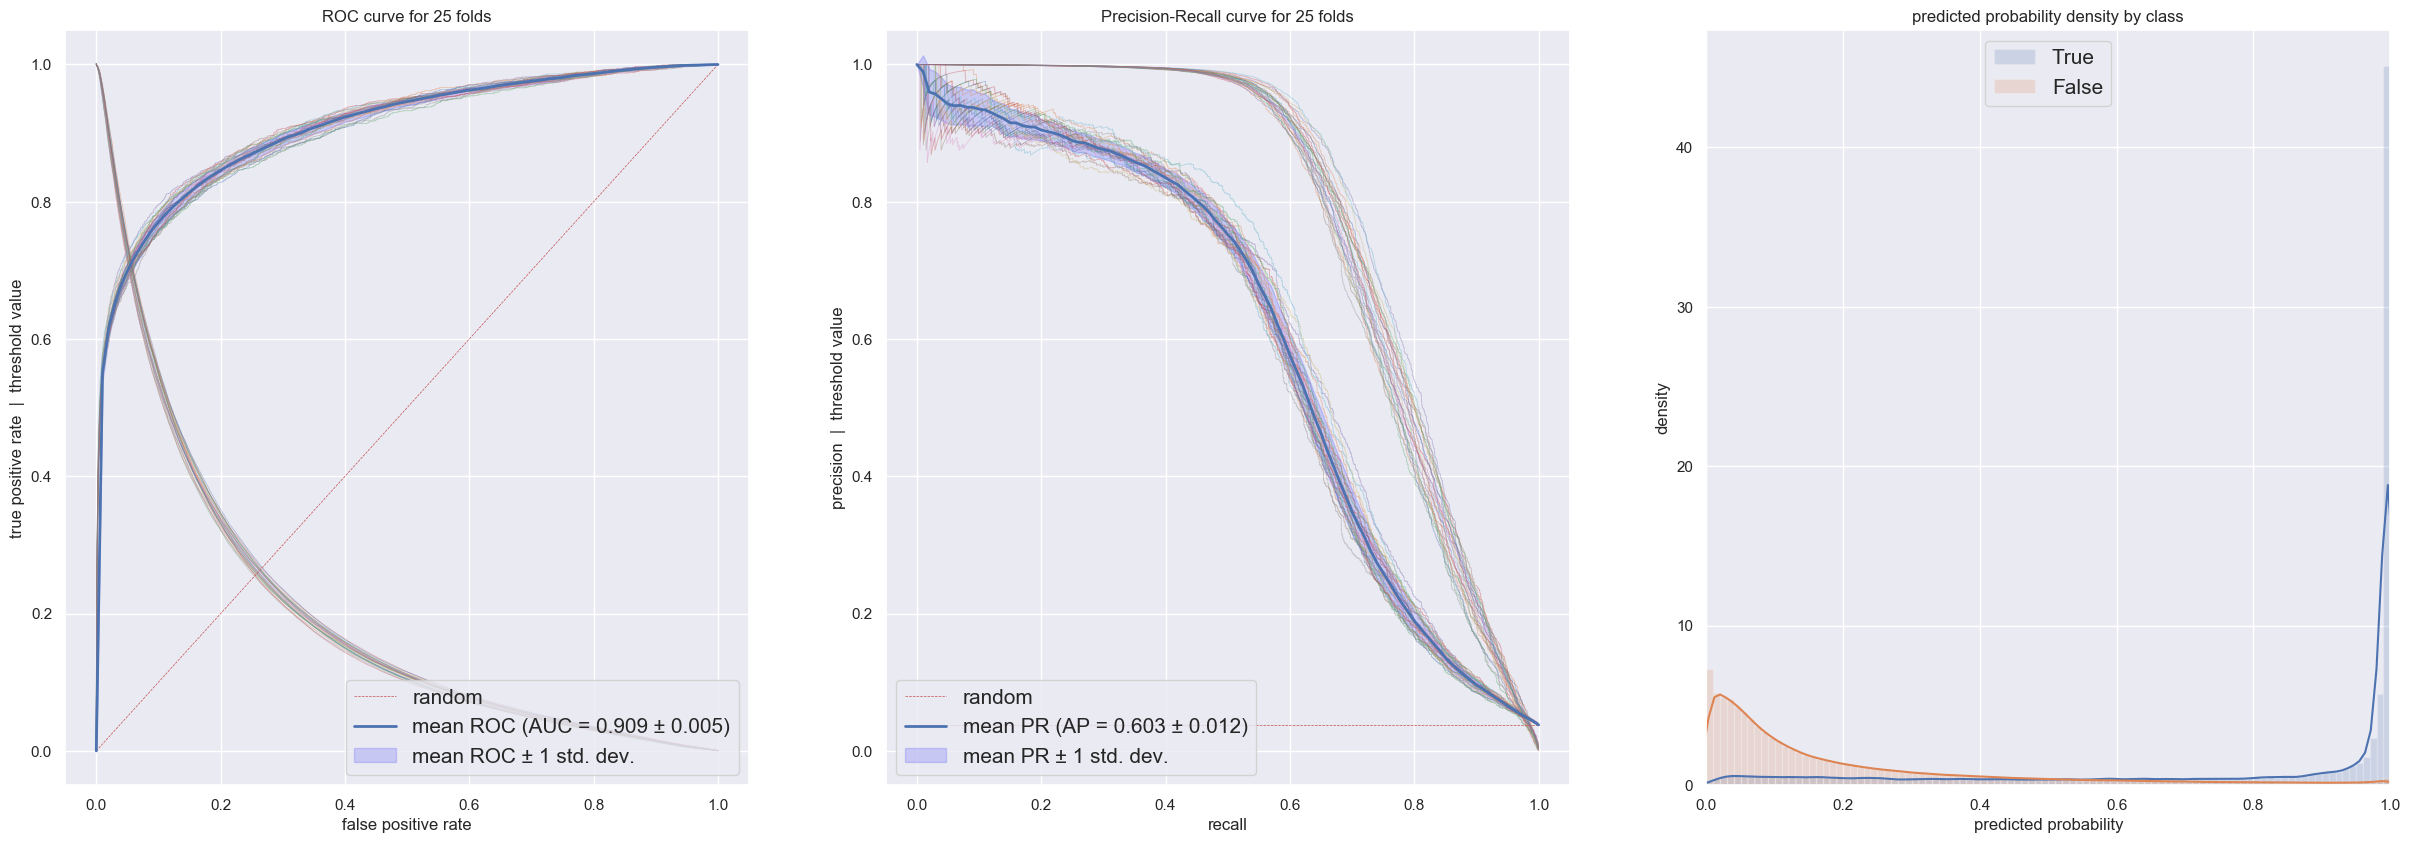

In [204]:
job_baseline.metrics.plot_threshold_decision_curves(show_folds_legend=False)

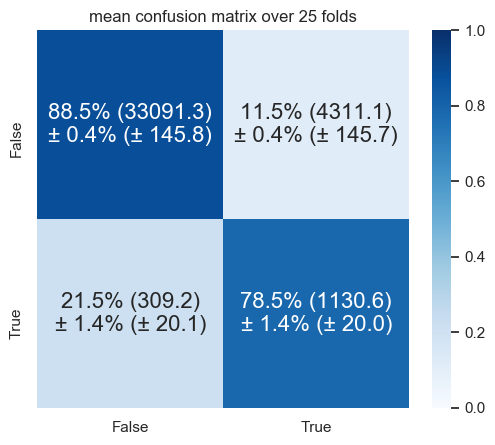

In [206]:
job_baseline.metrics.plot_mean_confusion_matrix()

## Evaluation by groups

In [367]:
job_list = {}

for group in features_groups.keys():
    name = 'without_{}'.format(group)
    print_md('**{}**'.format(name))
    
    job_list[name] = Selene_Job('fe_{}'.format(name), 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs')
    
    # get X and y
    print('Get X and y...', end= '')
    features = get_features(groups_to_remove = [group], individual_features_to_remove = ['VEP_SYMBOL'])
    start = time.time()
    data.process(features)
    X, y = data.get_X_and_y('all', 'all')
    print(' done! ({:.2f}s, {} raw features, {} features after processing)'.format(time.time() - start, len(features), X.shape[1]))
    
    # prepare job
    job_list[name].load_data(X, y)
    job.load_script(job_baseline.script_path)

**without_NGS**

<span style="color:red">Job < fe_without_NGS >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

Get X and y... done! (9.74s, 25 raw features, 80 features after processing)
➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_fe_without_NGS


<span style="color:green">Job < fe_without_NGS >: </span>✅ data loaded

➞ cp script.ipy from ../ssh_remote_jobs/job_fe_baseline/script.ipy to ../ssh_remote_jobs/job_fe_without_gnomAD_populations


<span style="color:green">Job < fe_without_gnomAD_populations >: </span>✅ script loaded

**without_genome**

<span style="color:red">Job < fe_without_genome >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

Get X and y... done! (9.85s, 34 raw features, 63 features after processing)
➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_fe_without_genome


<span style="color:green">Job < fe_without_genome >: </span>✅ data loaded

➞ cp script.ipy from ../ssh_remote_jobs/job_fe_baseline/script.ipy to ../ssh_remote_jobs/job_fe_without_gnomAD_populations


<span style="color:green">Job < fe_without_gnomAD_populations >: </span>✅ script loaded

**without_freq**

<span style="color:red">Job < fe_without_freq >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

Get X and y... done! (10.61s, 35 raw features, 90 features after processing)
➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_fe_without_freq


<span style="color:green">Job < fe_without_freq >: </span>✅ data loaded

➞ cp script.ipy from ../ssh_remote_jobs/job_fe_baseline/script.ipy to ../ssh_remote_jobs/job_fe_without_gnomAD_populations


<span style="color:green">Job < fe_without_gnomAD_populations >: </span>✅ script loaded

**without_somatic-driver**

<span style="color:red">Job < fe_without_somatic-driver >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

Get X and y... done! (8.27s, 32 raw features, 80 features after processing)
➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_fe_without_somatic-driver


<span style="color:green">Job < fe_without_somatic-driver >: </span>✅ data loaded

➞ cp script.ipy from ../ssh_remote_jobs/job_fe_baseline/script.ipy to ../ssh_remote_jobs/job_fe_without_gnomAD_populations


<span style="color:green">Job < fe_without_gnomAD_populations >: </span>✅ script loaded

**without_consequence**

<span style="color:red">Job < fe_without_consequence >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

Get X and y... done! (6.08s, 30 raw features, 64 features after processing)
➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_fe_without_consequence


<span style="color:green">Job < fe_without_consequence >: </span>✅ data loaded

➞ cp script.ipy from ../ssh_remote_jobs/job_fe_baseline/script.ipy to ../ssh_remote_jobs/job_fe_without_gnomAD_populations


<span style="color:green">Job < fe_without_gnomAD_populations >: </span>✅ script loaded

**without_AF**

<span style="color:red">Job < fe_without_AF >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

Get X and y... done! (10.86s, 24 raw features, 78 features after processing)
➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_fe_without_AF


<span style="color:green">Job < fe_without_AF >: </span>✅ data loaded

➞ cp script.ipy from ../ssh_remote_jobs/job_fe_baseline/script.ipy to ../ssh_remote_jobs/job_fe_without_gnomAD_populations


<span style="color:green">Job < fe_without_gnomAD_populations >: </span>✅ script loaded

In [368]:
job_list = {}
for group in features_groups.keys():
    name = 'without_{}'.format(group)
    job_list[name] = Selene_Job('fe_{}'.format(name), 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs', load_from_id='True')

<span style="color:green">Job < fe_without_NGS >: </span>✅ job found and reloaded

<span style="color:green">Job < fe_without_genome >: </span>✅ job found and reloaded

<span style="color:green">Job < fe_without_freq >: </span>✅ job found and reloaded

<span style="color:green">Job < fe_without_somatic-driver >: </span>✅ job found and reloaded

<span style="color:green">Job < fe_without_consequence >: </span>✅ job found and reloaded

<span style="color:green">Job < fe_without_AF >: </span>✅ job found and reloaded

In [369]:
for key, job in job_list.items():
    print_md('**{}**'.format(key))
    job.run(n_jobs=20, short_job=True)

**without_NGS**

➞ scp ../ssh_remote_jobs/job_fe_without_NGS to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
job_output.txt                                100% 1384   157.5KB/s   00:00    
metrics.pkl                                   100%   20MB  12.2MB/s   00:01    
script.ipy                                    100%  910   126.7KB/s   00:00    
X.pkl                                         100%   47MB  11.8MB/s   00:04    
y.pkl                                         100% 3225KB   6.8MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_fe_without_NGS
Job <28977115> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J fe_without_NGS -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < fe_without_NGS >: </span>✅ submitted<br>

**without_genome**

➞ scp ../ssh_remote_jobs/job_fe_without_genome to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
job_output.txt                                100% 1393    89.9KB/s   00:00    
metrics.pkl                                   100%   32MB  10.8MB/s   00:02    
script.ipy                                    100%  910   138.0KB/s   00:00    
X.pkl                                         100%   59MB  14.8MB/s   00:04    
y.pkl                                         100% 3225KB  13.4MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_fe_without_genome
Job <28977117> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J fe_without_genome -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < fe_without_genome >: </span>✅ submitted<br>

**without_freq**

➞ scp ../ssh_remote_jobs/job_fe_without_freq to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
job_output.txt                                100% 1389   105.1KB/s   00:00    
metrics.pkl                                   100%   32MB  14.0MB/s   00:02    
script.ipy                                    100%  910   119.6KB/s   00:00    
X.pkl                                         100%   62MB  15.5MB/s   00:04    
y.pkl                                         100% 3225KB  15.3MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_fe_without_freq
Job <28977118> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J fe_without_freq -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < fe_without_freq >: </span>✅ submitted<br>

**without_somatic-driver**

➞ scp ../ssh_remote_jobs/job_fe_without_somatic-driver to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
job_output.txt                                100% 1419   100.7KB/s   00:00    
metrics.pkl                                   100%   32MB  13.9MB/s   00:02    
script.ipy                                    100%  910   111.8KB/s   00:00    
X.pkl                                         100%   56MB  14.8MB/s   00:03    
y.pkl                                         100% 3225KB  13.8MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_fe_without_somatic-driver
Job <28977123> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J fe_without_somatic-driver -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < fe_without_somatic-driver >: </span>✅ submitted<br>

**without_consequence**

➞ scp ../ssh_remote_jobs/job_fe_without_consequence to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
job_output.txt                                100% 1408   132.3KB/s   00:00    
metrics.pkl                                   100%   32MB  12.8MB/s   00:02    
script.ipy                                    100%  910    97.3KB/s   00:00    
X.pkl                                         100%   50MB  10.7MB/s   00:04    
y.pkl                                         100% 3225KB  11.4MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_fe_without_consequence
Job <28977126> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J fe_without_consequence -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < fe_without_consequence >: </span>✅ submitted<br>

**without_AF**

➞ scp ../ssh_remote_jobs/job_fe_without_AF to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
job_output.txt                                100% 1381     1.5KB/s   00:00    
metrics.pkl                                   100%   32MB  11.8MB/s   00:02    
script.ipy                                    100%  910    97.8KB/s   00:00    
X.pkl                                         100%   45MB  12.5MB/s   00:03    
y.pkl                                         100% 3225KB  12.6MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_fe_without_AF
Job <28977127> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J fe_without_AF -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < fe_without_AF >: </span>✅ submitted<br>

In [370]:
for key, job in job_list.items():
    print_md('**{}**'.format(key))
    job.get_results()

**without_NGS**

<span style="color:red">Job < fe_without_NGS >: </span>⚠️ does not exist on the cluster, is not done yet or an error occured before the creation of `metrics.pkl`<br>

**without_genome**

<span style="color:red">Job < fe_without_genome >: </span>⚠️ does not exist on the cluster, is not done yet or an error occured before the creation of `metrics.pkl`<br>

**without_freq**

<span style="color:red">Job < fe_without_freq >: </span>⚠️ does not exist on the cluster, is not done yet or an error occured before the creation of `metrics.pkl`<br>

**without_somatic-driver**

<span style="color:red">Job < fe_without_somatic-driver >: </span>⚠️ does not exist on the cluster, is not done yet or an error occured before the creation of `metrics.pkl`<br>

**without_consequence**

<span style="color:red">Job < fe_without_consequence >: </span>⚠️ does not exist on the cluster, is not done yet or an error occured before the creation of `metrics.pkl`<br>

**without_AF**

<span style="color:red">Job < fe_without_AF >: </span>⚠️ does not exist on the cluster, is not done yet or an error occured before the creation of `metrics.pkl`<br>

<Figure size 600x600 with 0 Axes>

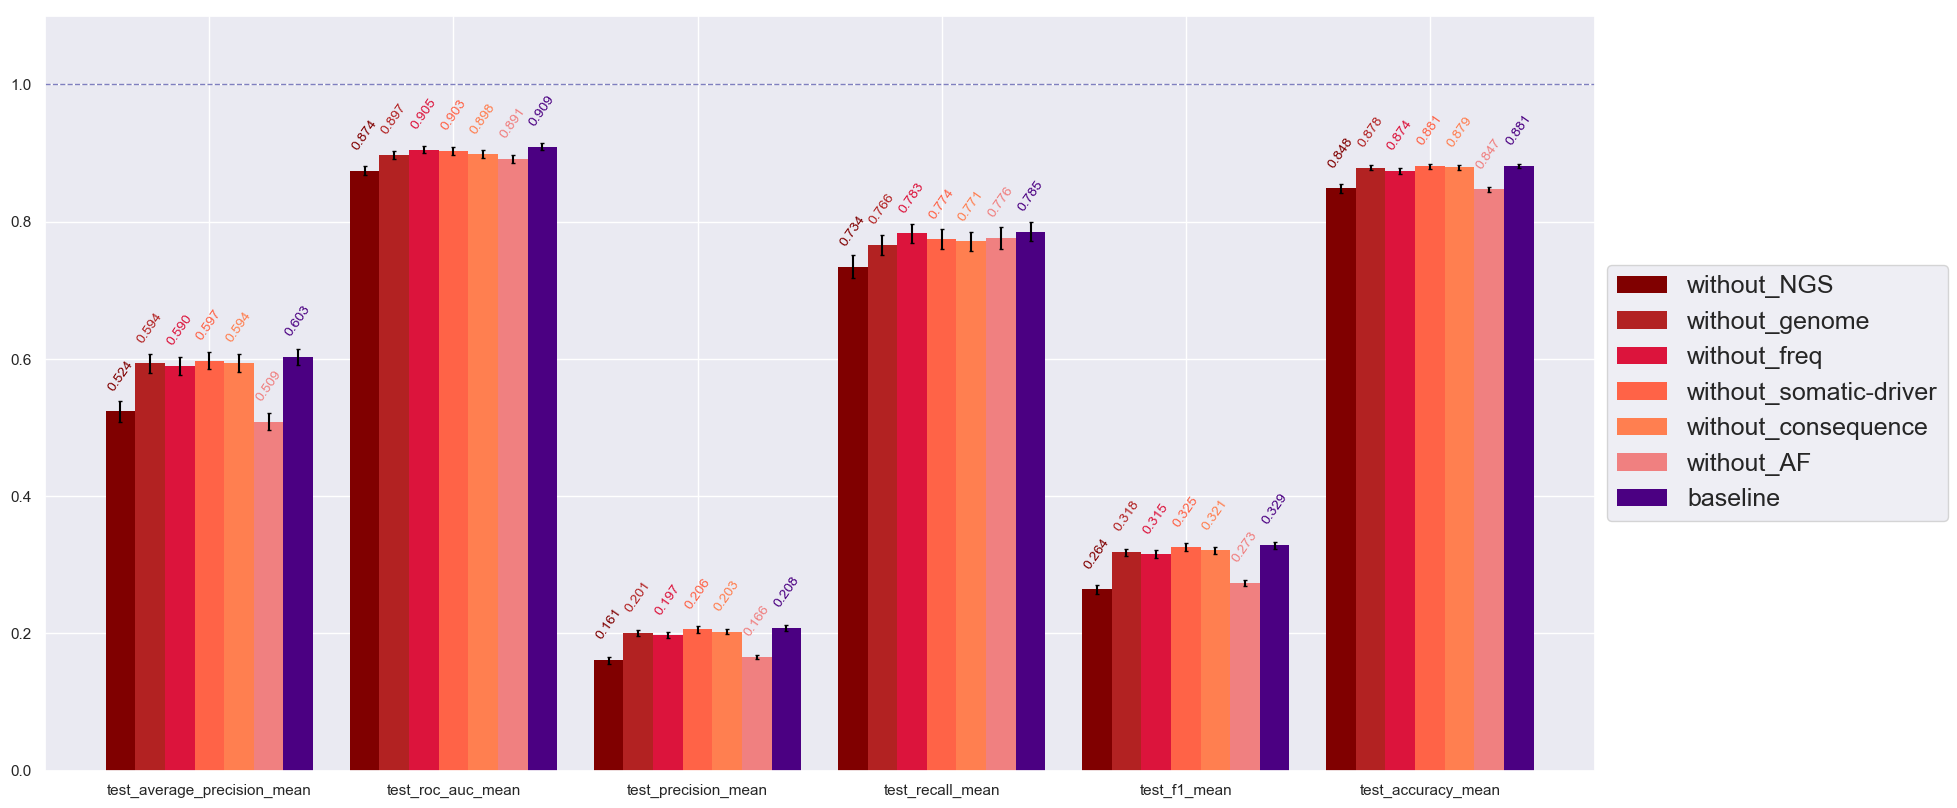

In [351]:
%run ../summary.py
# create summary
summary = Summary()

# fill summary
for key, color in zip(job_list, ['maroon', 'firebrick', 'crimson', 'tomato', 'coral', 'lightcoral']):
    summary.add(job_list[key].metrics, key, color)
summary.add(job_baseline.metrics, 'baseline', 'indigo')

# plot summary
summary.display()
summary.plot()

## Without gnomAD populations

In [371]:
job = Selene_Job('fe_without_gnomAD_populations', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs')

features = get_features(individual_features_to_remove = AF_populations + ['VEP_SYMBOL'])
data.process(features)
X, y = data.get_X_and_y('all', 'all')

job.load_data(X, y)
job.load_script(job_baseline.script_path)

<span style="color:red">Job < fe_without_gnomAD_populations >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_fe_without_gnomAD_populations


<span style="color:green">Job < fe_without_gnomAD_populations >: </span>✅ data loaded

➞ cp script.ipy from ../ssh_remote_jobs/job_fe_baseline/script.ipy to ../ssh_remote_jobs/job_fe_without_gnomAD_populations


<span style="color:green">Job < fe_without_gnomAD_populations >: </span>✅ script loaded

In [372]:
job = Selene_Job('fe_without_gnomAD_populations', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs', load_from_id=True)

<span style="color:green">Job < fe_without_gnomAD_populations >: </span>✅ job found and reloaded

In [373]:
job.run(n_jobs=20, short_job=True)

➞ scp ../ssh_remote_jobs/job_fe_without_gnomAD_populations to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
job_output.txt                                100% 1429   169.1KB/s   00:00    
metrics.pkl                                   100%   32MB  15.9MB/s   00:02    
script.ipy                                    100%  911    98.4KB/s   00:00    
X.pkl                                         100%   53MB  11.7MB/s   00:04    
y.pkl                                         100% 3225KB  13.6MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_fe_without_gnomAD_populations
Job <28977131> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J fe_without_gnomAD_populations -We 59 -n 20 -R "span[ptile=5]" "ipython 

<span style="color:green">Job < fe_without_gnomAD_populations >: </span>✅ submitted<br>

In [375]:
job.get_results()

<span style="color:red">Job < fe_without_gnomAD_populations >: </span>⚠️ does not exist on the cluster, is not done yet or an error occured before the creation of `metrics.pkl`<br>

In [376]:
job.metrics.print_mean()

AttributeError: 'Selene_Job' object has no attribute 'metrics'

In [ ]:
%run ../summary.py
# create summary
summary = Summary()

# fill summary
summary_2.add(job_baseline.metrics, 'baseline', 'indigo')
summary_2.add(job.metrics, 'without_gnomAD_populations', 'firebrick')

# plot summary
summary.display()
summary.plot()
#summary_2.plot_cv_curves()

In [ ]:
#summary_2.plot_2_vs_2()

In [150]:
features = get_features(individual_features_to_remove = AF_populations + ['VEP_SYMBOL'])
data.process(features)
X, y = data.get_X_and_y('all', 'all')

metrics = Metrics(model_RF, X, y, cv_strategy, n_jobs=5)

Run model... done! (320.68s)


## New features tried

In [11]:
summary_4 = Summary()
summary_4.add(metrics_baseline, 'baseline', 'indigo')